# Hopfield recall. Mute

Take a memory cluster, mute some nodes. See if it recalls.

Mute nodes: 1) Mute half. Show recalled signal. 2) Mute the most active. Show summary

If it works, can be an interesting application. Suppose you have a failure node in a network, but you need to know a signal. You can learn based on the previous signal to recover the signal of the failure node.

Result: recall works even if we mute signal on a half of the nodes (including the core events)

In [1]:
import numpy as np
from matplotlib import pyplot as pl
import matplotlib.colors as colors
from scipy import sparse
%matplotlib inline

### Prepare data

In [2]:
PATH_DATA = "/mnt/data/git/WikiBrain/src/main/resources/hopfield/"

In [3]:
#signal matrix (pages_ x time_)
content = np.load(PATH_DATA + "content.npy")

Match Wiki page ids with row numbers in <code>content</code> matrix to link it with an adjacency matrix

In [4]:
ids = []
for row in content:
    ids.append(int(row[0]))

In [5]:
ids_dict = {}
for i, a in enumerate(ids):
    ids_dict[a] = i

In [6]:
ids_dict_swap = {}
for i, a in enumerate(ids):
    ids_dict_swap[i] = a

Get cluster specific pages. Get rows of the content matrix specific to the cluster

In [7]:
CHARLIE_HEBDO = '/clusters/Charlie_Hebdo_one_week_5_12_January.csv'
GERMANWINGS = '/clusters/GermanWings_week.csv'

FERGUSON_STDDEV = '/clusters/ferguson_week_stddev.csv'
CHARLIE_STDDEV = '/clusters/charlie_week_stddev.csv'
GERMANWINGS_STDDEV = '/clusters/germanwings_week_stddev.csv'

In [8]:
FERGUSON_ADJ = '/stddev/edges_ferguson.csv'
CHARLIE_ADJ = '/stddev/edges_charlie.csv'
GERMANWINGS_ADJ = '/stddev/edges_germanwings.csv'

In [10]:
LABELS = FERGUSON_STDDEV
ADJ = FERGUSON_ADJ

In [11]:
with open(PATH_DATA + LABELS) as f:
    cluster = f.readlines()
cluster = [x.strip() for x in cluster]

In [12]:
cluster = map(lambda l: (int(l[0]), l[1]), map(lambda t: t.split(','), cluster))

In [13]:
import string
printable = set(string.printable)
cluster = map(lambda l: (int(l[0]), filter(lambda x: x in printable, l[1])), cluster)

In [14]:
cluster = dict(cluster) # (id:title)

In [15]:
#these are the nodes to mute
cluster_rows = [ids_dict[pId] for pId in cluster.keys()]

Read adjacency matrix and link it to content matrix. In other words, link signal to graph

In [17]:
import csv
with open(PATH_DATA + ADJ) as f:
    data=[tuple(line) for line in csv.reader(f)]

In [18]:
# adjacency for a cluster
list_of_ids = [ids_dict_swap[x] for x in cluster_rows]
row = [ids_dict[int(line[0])] for line in data]
col = [ids_dict[int(line[1])] for line in data]
data = [float(line[2]) if (float(line[2]) > 1.0 and int(line[0]) in list_of_ids and int(line[1]) in list_of_ids) else 0.0 for line in data] #learned

In [19]:
from scipy.sparse import csr_matrix

In [20]:
W = csr_matrix((data, (row, col)), shape=(len(ids_dict), len(ids_dict)))

In [21]:
W = W + W.transpose()

Getters by page title, row in content, and id by title

In [22]:
import csv
with open(PATH_DATA + 'id_title.csv') as f:
    data_id_title=[tuple([int(line[0]), line[1]]) for line in csv.reader(f)]

In [23]:
data_id_title = dict(data_id_title)

In [24]:
#for example
title = 'Je_suis_Charlie'

In [25]:
page_id = [ key for key,val in data_id_title.items() if val==title ][0]

In [26]:
data_id_title[page_id]

'Je_suis_Charlie'

In [27]:
nRow = ids_dict[page_id]
print 'Row number for page ' + title +  ": " + str(nRow)

Row number for page Je_suis_Charlie: 30604


In [28]:
def getTitleByRow(requested_row):
    requested_id = ids_dict_swap[requested_row]
    return data_id_title[requested_id]

Mute some nodes in the cluster. IDs to mute are in <code>cluster_rows</code>. When mutting, assign <code>-1</code>

In [29]:
#mute a particular node (e.g. Charlie Hebdo 110593, Charlie Hebdo Shooting 14957, Je suis Charlie 30604)
# content[110593] = -1
# content[14957] = -1
# content[30604] = -1

In [30]:
# mute nodes from cluster_rows
for row in cluster_rows[:len(cluster_rows)/2]:
    content[row] = -1

In [31]:
getTitleByRow(cluster_rows[10])

'O._J._Simpson_murder_case'

NFL cluster. Specific case. Get only team pages

In [32]:
# nfl_teams = ['Buffalo_Bills','Miami_Dolphins','New_England_Patriots','New_York_Jets','Baltimore_Ravens','Cincinnati_Bengals','Cleveland_Browns','Pittsburgh_Steelers','Houston_Texans','Indianapolis_Colts','Jacksonville_Jaguars','Tennessee_Titans','Denver_Broncos','Kansas_City_Chiefs','Los_Angeles_Chargers','Oakland_Raiders','Dallas_Cowboys','New_York_Giants','Philadelphia_Eagles','Washington_Redskins','Chicago_Bears','Detroit_Lions','Green_Bay_Packers','Minnesota_Vikings','Atlanta_Falcons','Carolina_Panthers','New_Orleans_Saints','Tampa_Bay_Buccaneers','Arizona_Cardinals','Los_Angeles_Rams','San_Francisco_49ers','Seattle_Seahawks']
# page_ids = [ key for key,val in data_id_title.items() if val in nfl_teams ]
# cluster_rows = [ids_dict[pID] for pID in page_ids]

Binarize signal (1 if active, -1 if inactive). To simplify idea of Hopfield recall process

In [33]:
def binarize(x):
    if x>0.0:
        x = 1.0
    else: x = -1.0
    return x

In [34]:
binarized = np.array([[binarize(x) for x in row] for row in content])

Low pass filter to see trends in a signal

In [35]:
def savitzky_golay(y, window_size=747, order=2, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

Data for plotting

In [36]:
months = ['October', 'November', 'December', 'January', 'February', 'March', 'April']
x_month = [i for i in np.arange(8*24, len(content[0]), 30*24)]
x_month[1] = x_month[1] + 24 #October
x_month[2] = x_month[2] + 24 #November
x_month[3] = x_month[3] + 48 #December
x_month[4] = x_month[4] + 72 #January
x_month[5] = x_month[5] + 24 #February
x_month[6] = x_month[6] + 48 #March
x_month[7] = x_month[7] + 48 #April

In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = 90, 40
rcParams['xtick.labelsize'] = 50
rcParams['ytick.labelsize'] = 50
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

Summary of the original signal (sum activity over pages per hour)

In [38]:
summary = np.array(csr_matrix(binarized+1).sum(axis = 0))[0]

In [40]:
#filter over 169 hours (a week) time window with a polynomial of order 2
#month = 747 hours
filtered = savitzky_golay(summary[1:], window_size=23)

Degrade signal. Flip a fraction of activations

In [41]:
def degrade(patterns,noise):
    #This allows you to add noise to a pattern
    sgn=np.vectorize(lambda x: x*-1 if np.random.random()<noise else x)
    out=sgn(patterns)
    return out

In [42]:
#degraded = csr_matrix(degrade(np.array(binarized), 0.2))
degraded = csr_matrix(binarized)

### Recall process

In [43]:
r,p = degraded.shape

In [44]:
def recall(W, patterns, steps=5):
    #The tests the network. You give it a pattern and see what it produces
    from numpy import vectorize, dot #vector calculus functions
    sgn = vectorize(lambda x: -1 if x<0 else +1) # convert input pattern into a -1/+1 pattern
    for _ in xrange(steps): #over a number of iterations (defined by 'steps')    
        print "." * (_ + 1)
        patterns = W.dot(patterns) #adjust the neuron activity to reflect the weights
        data = patterns.data
        patterns.data = np.array([-1 if x<0 else +1 for x in data])
    return patterns.todense() #return the final pattern

In [45]:
recalled = recall(W/r, degraded, steps=1)

.


In [46]:
#if we want to plot a cluster titles
titles = [getTitleByRow(row).decode('utf-8') for row in cluster_rows]

Plot a selected cluster

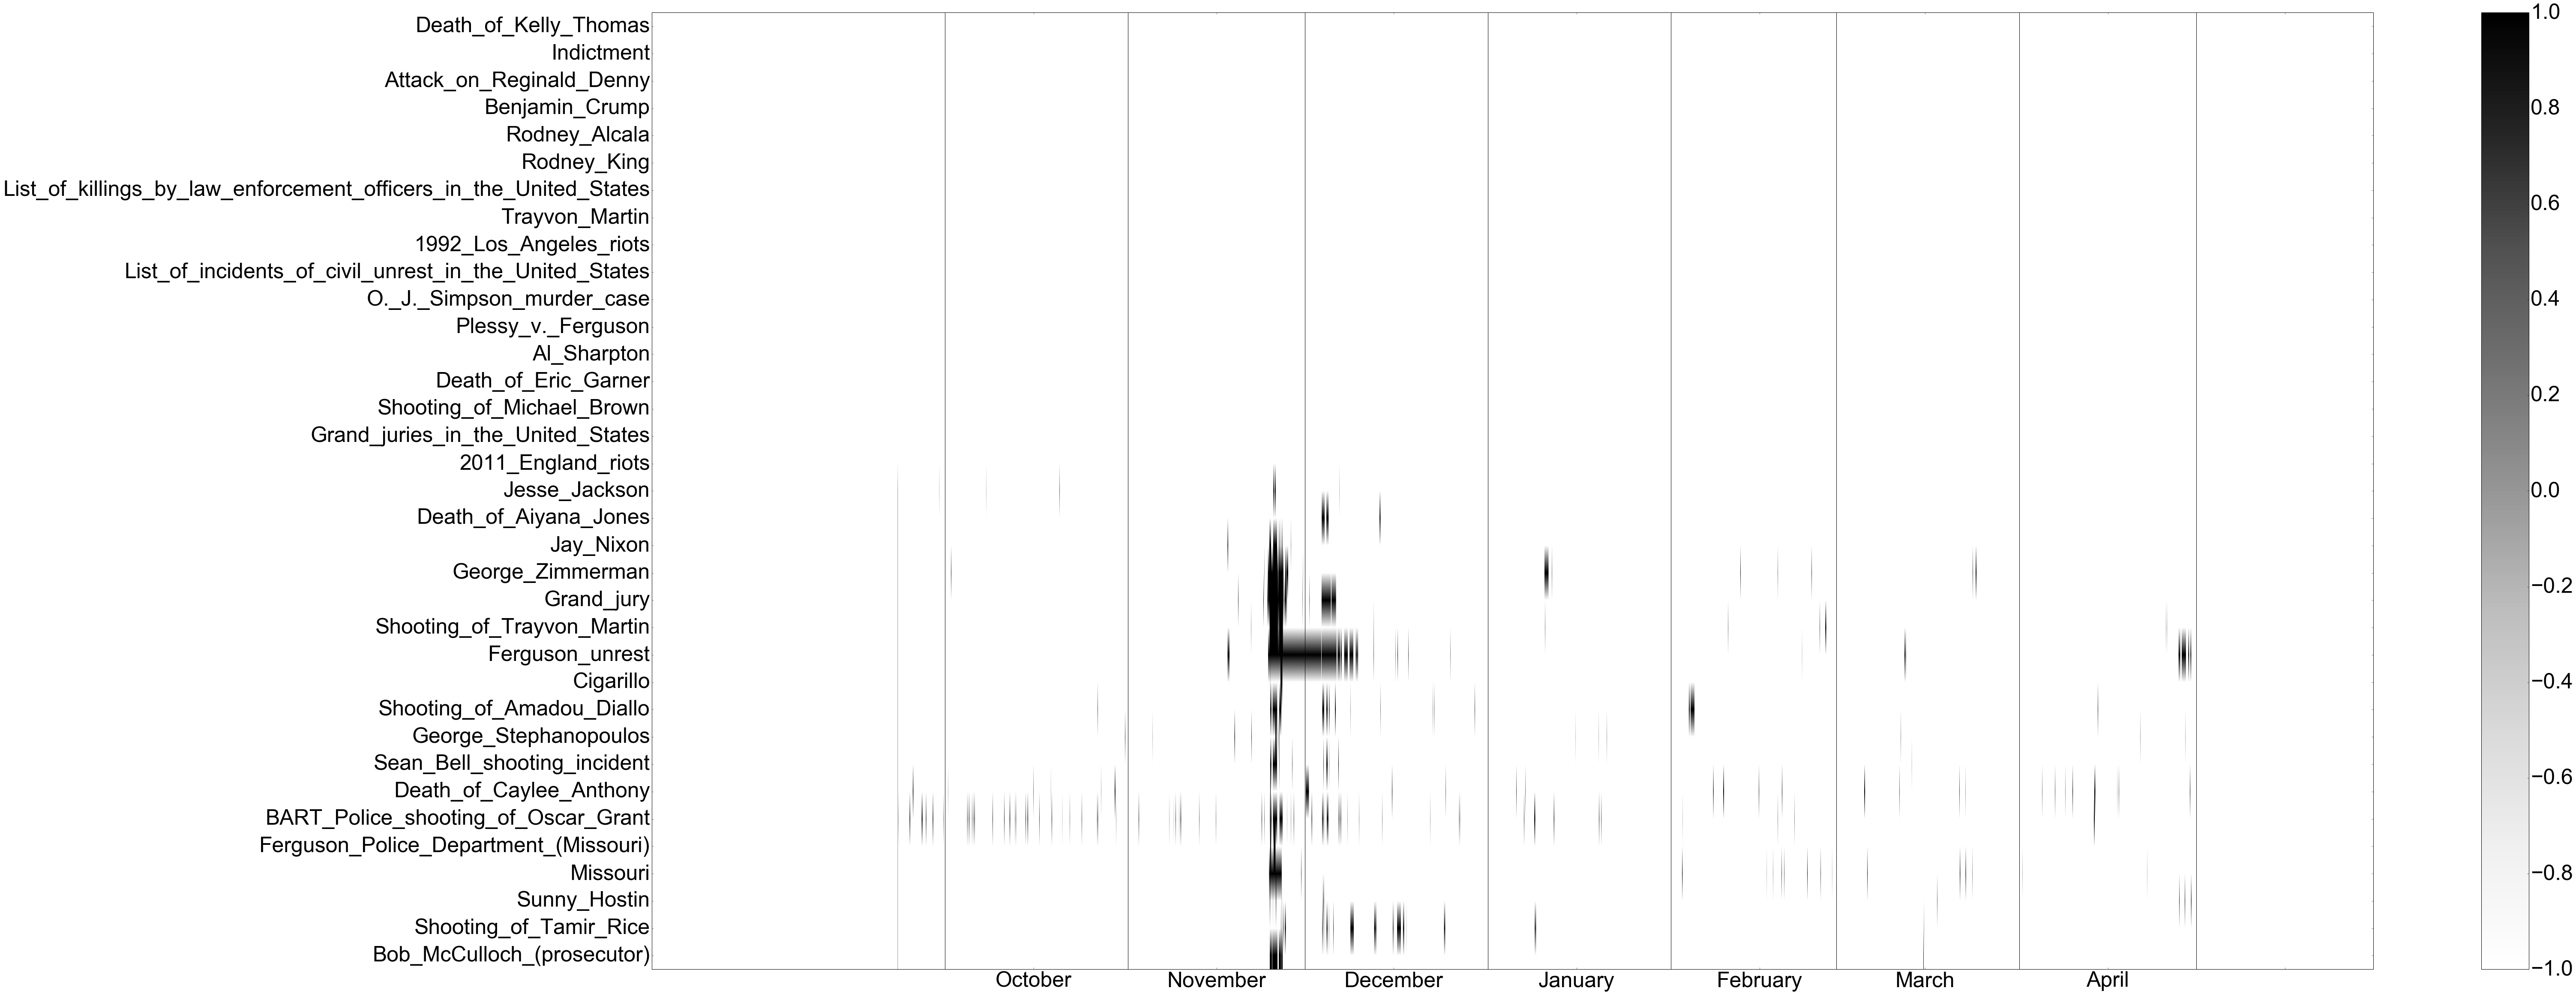

In [59]:
#original
# pl.figure(figsize=(100,300))
pl.imshow(binarized[cluster_rows, :], cmap="Greys", aspect='auto')
for xc in x_month:
    pl.axvline(x=xc, linewidth=1, color = 'black')
pl.xticks([i + 15*24 for i in x_month], [month for month in months])
pl.yticks(range(0,len(titles)), titles)
pl.colorbar()

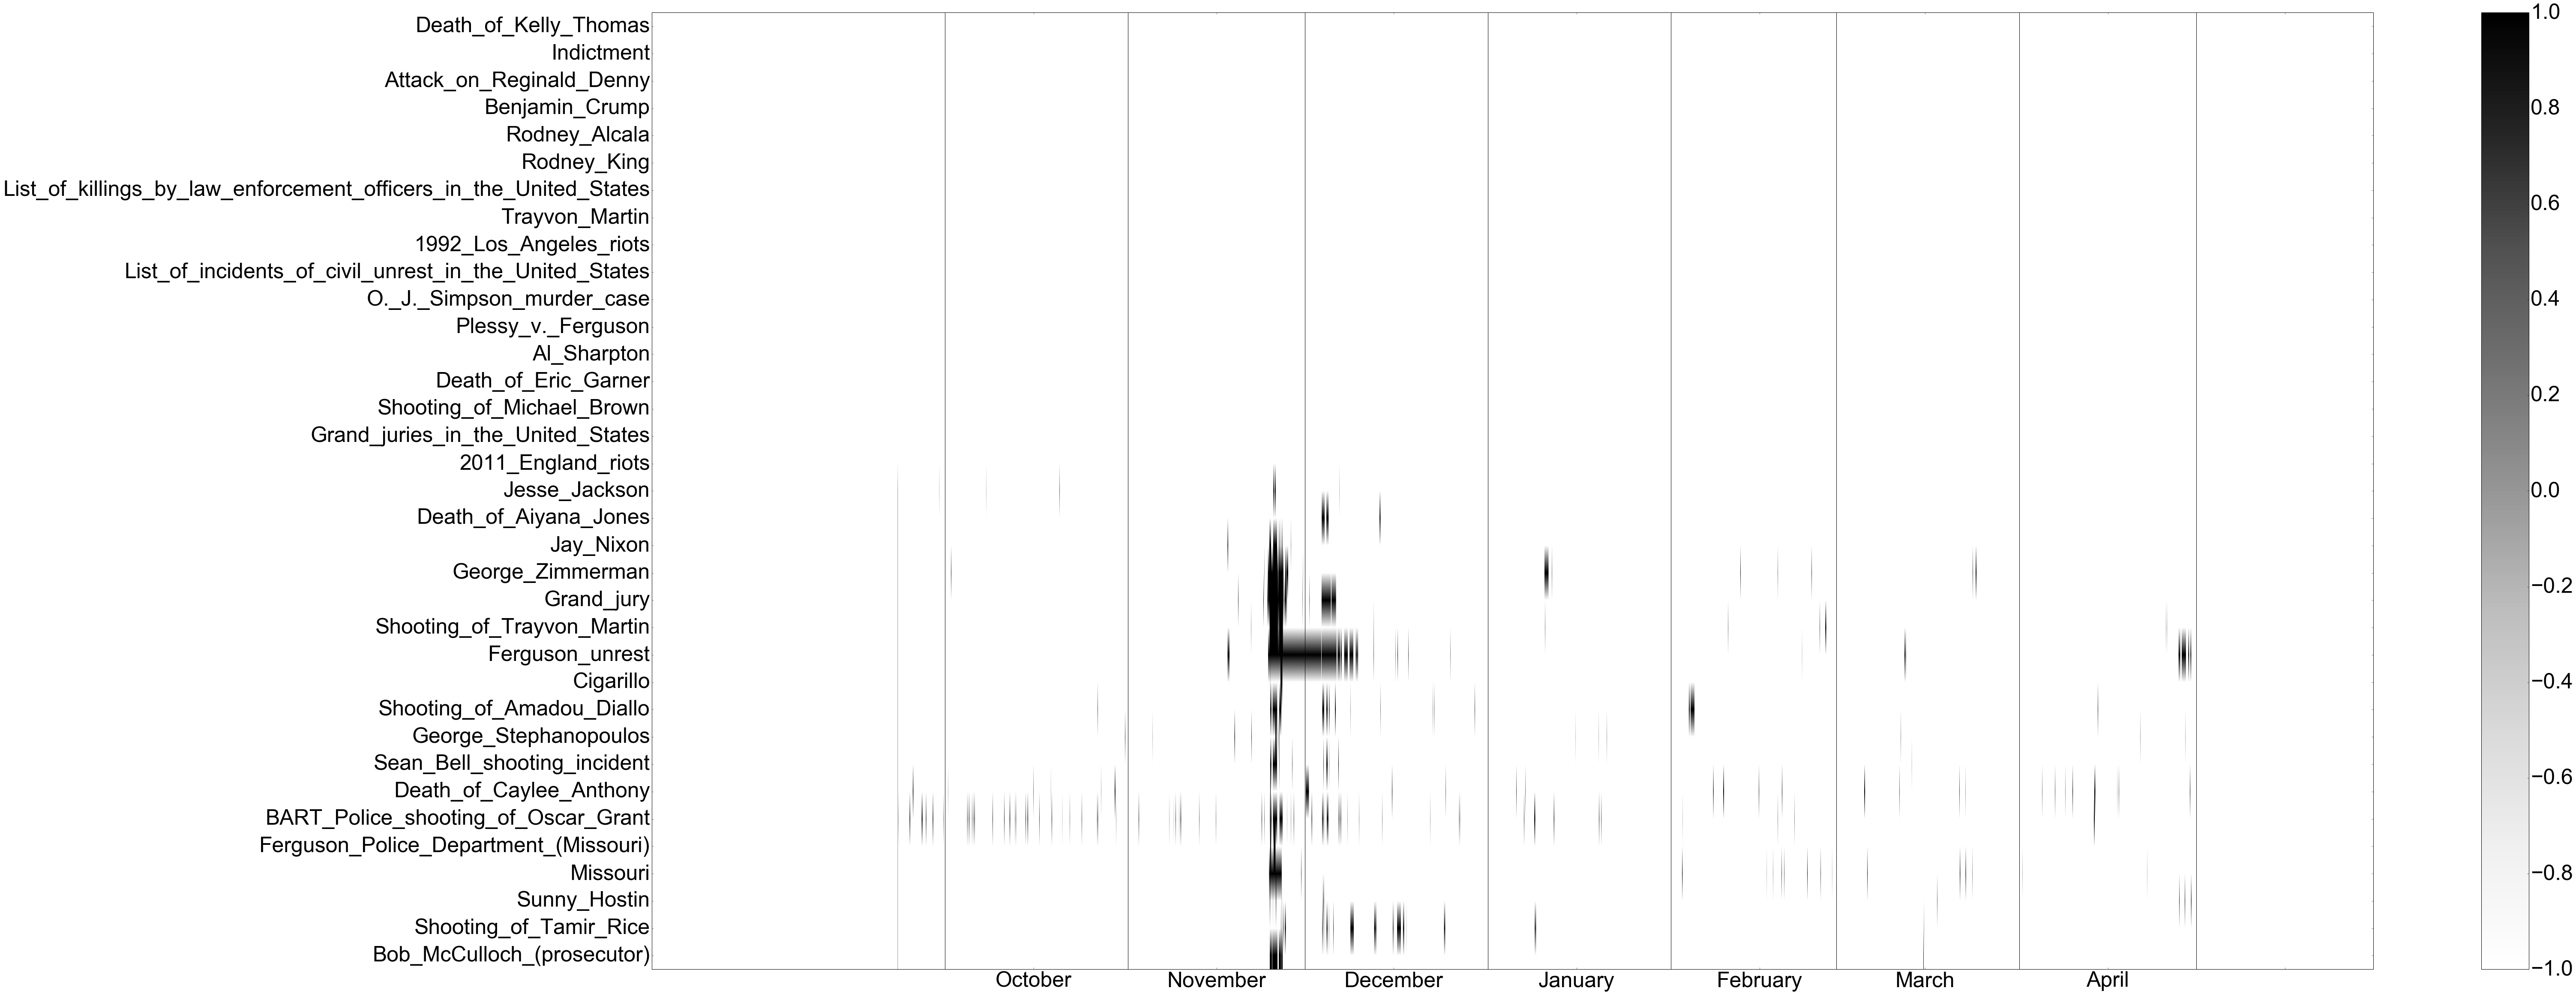

In [48]:
# #degraded
# pl.figure(figsize=(100,200))
# # pl.figure(figsize=(100,50))
# pl.imshow(degraded.todense()[nRow-10:nRow+10, :], cmap="Greys", aspect='auto')
pl.imshow(degraded.todense()[cluster_rows, :], cmap="Greys", aspect='auto')
for xc in x_month:
    pl.axvline(x=xc, linewidth=1, color = 'black')
pl.xticks([i + 15*24 for i in x_month], [month for month in months])
pl.yticks(range(0,len(titles)), titles)
pl.colorbar()

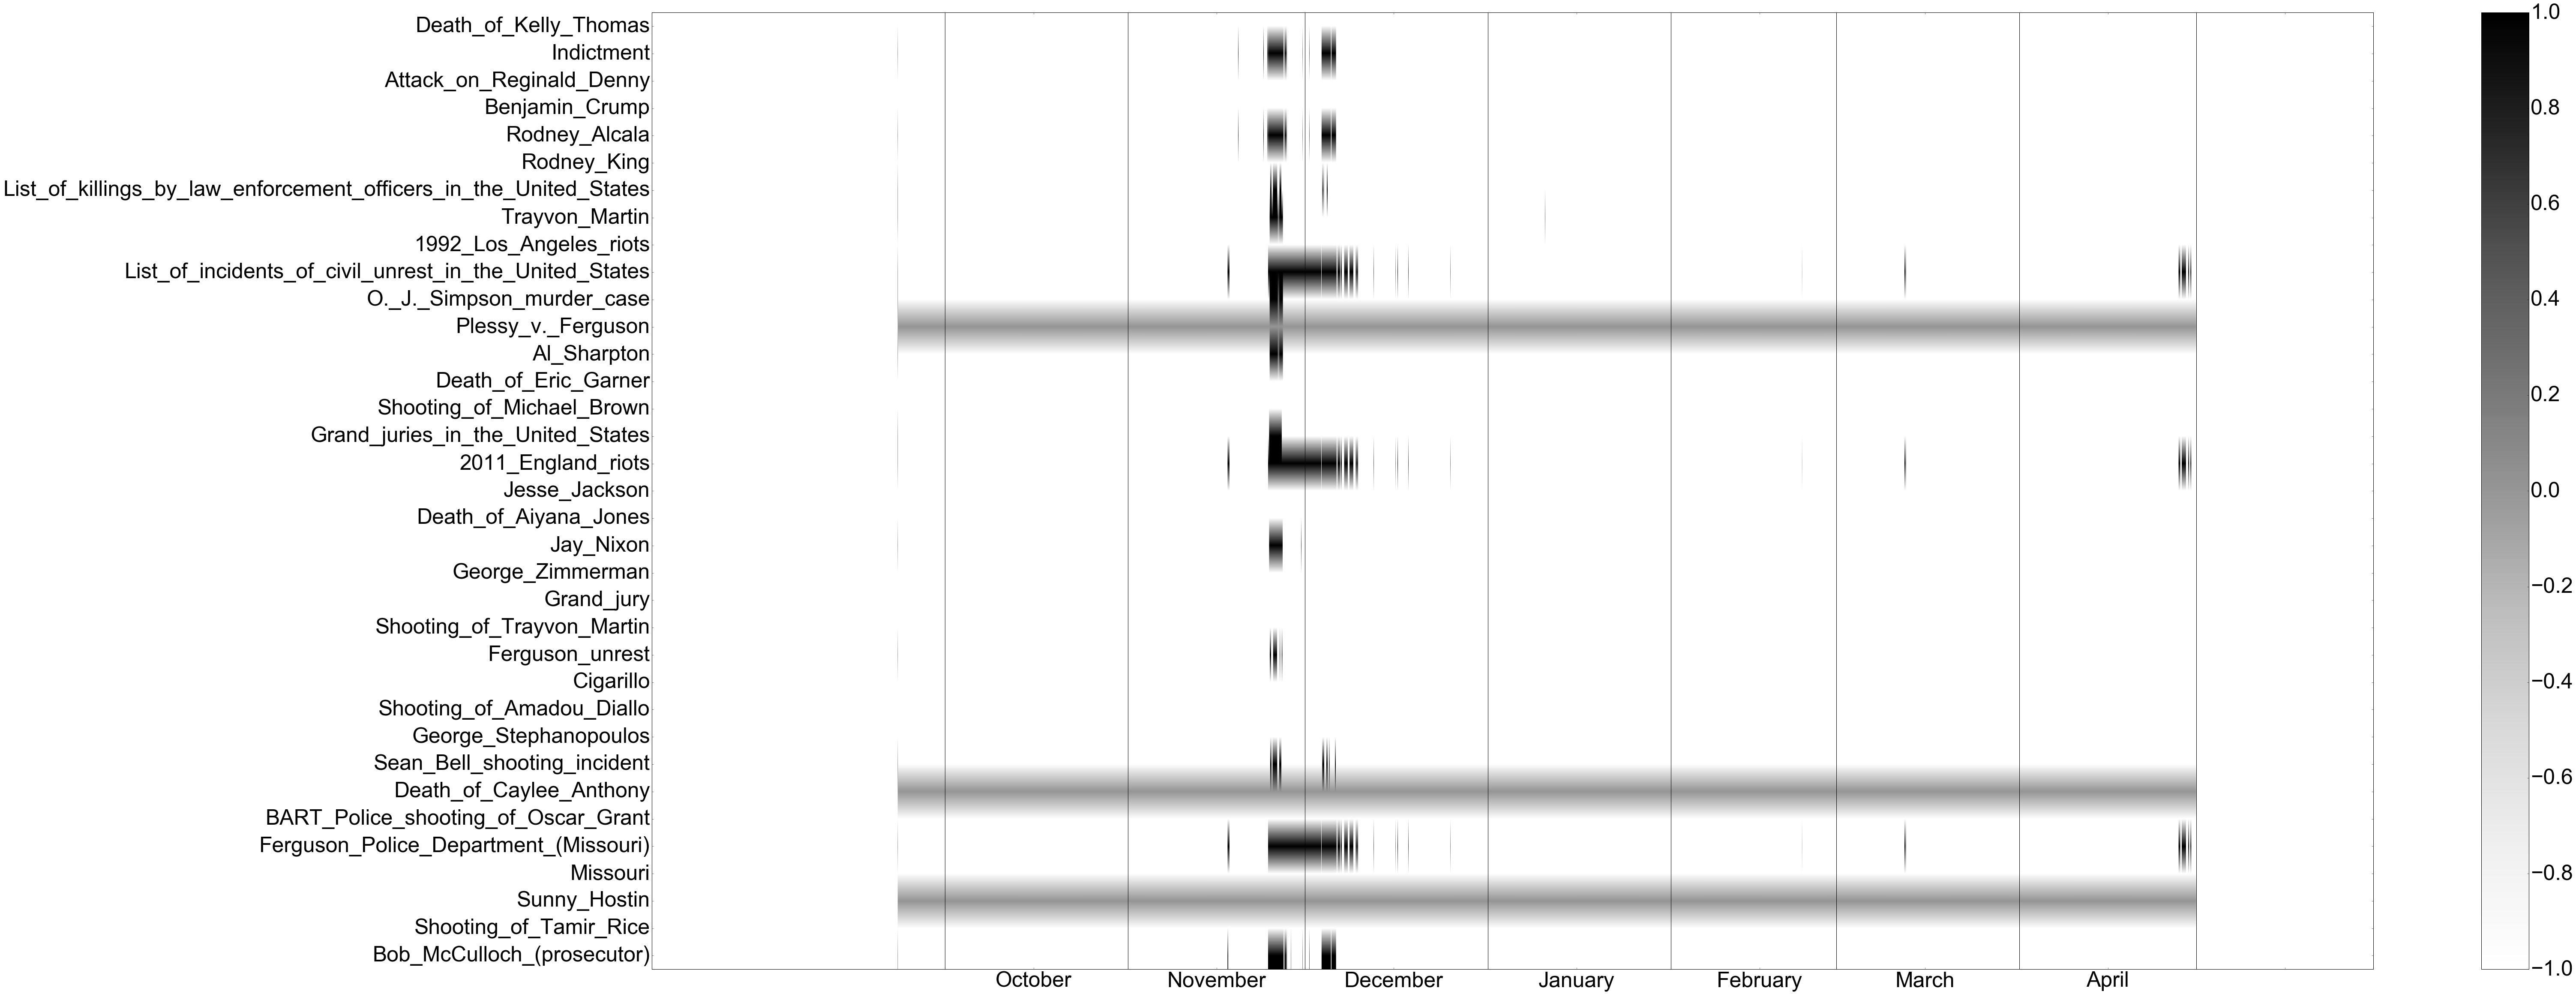

In [49]:
#recalled
# pl.figure(figsize=(100,200))
# pl.figure(figsize=(100,50))
# pl.imshow(recalled[nRow-10:nRow+10, :], cmap="Greys", aspect='auto')
pl.imshow(recalled[cluster_rows, :], cmap="Greys", aspect='auto')
for xc in x_month:
    pl.axvline(x=xc, linewidth=1, color = 'black')
pl.xticks([i + 15*24 for i in x_month], [month for month in months])
pl.yticks(range(0,len(titles)), titles)
pl.colorbar()

Summary of the signal

In [50]:
summary_recalled = np.array(csr_matrix(recalled+1).sum(axis = 0))[0]

In [63]:
summary_degraded = np.array(csr_matrix(degraded.todense()[cluster_rows, :]+1).sum(axis = 0))[0]

In [54]:
filtered_recalled = savitzky_golay(summary_recalled, window_size=23)

In [64]:
filtered_degraded = savitzky_golay(summary_degraded, window_size=23)

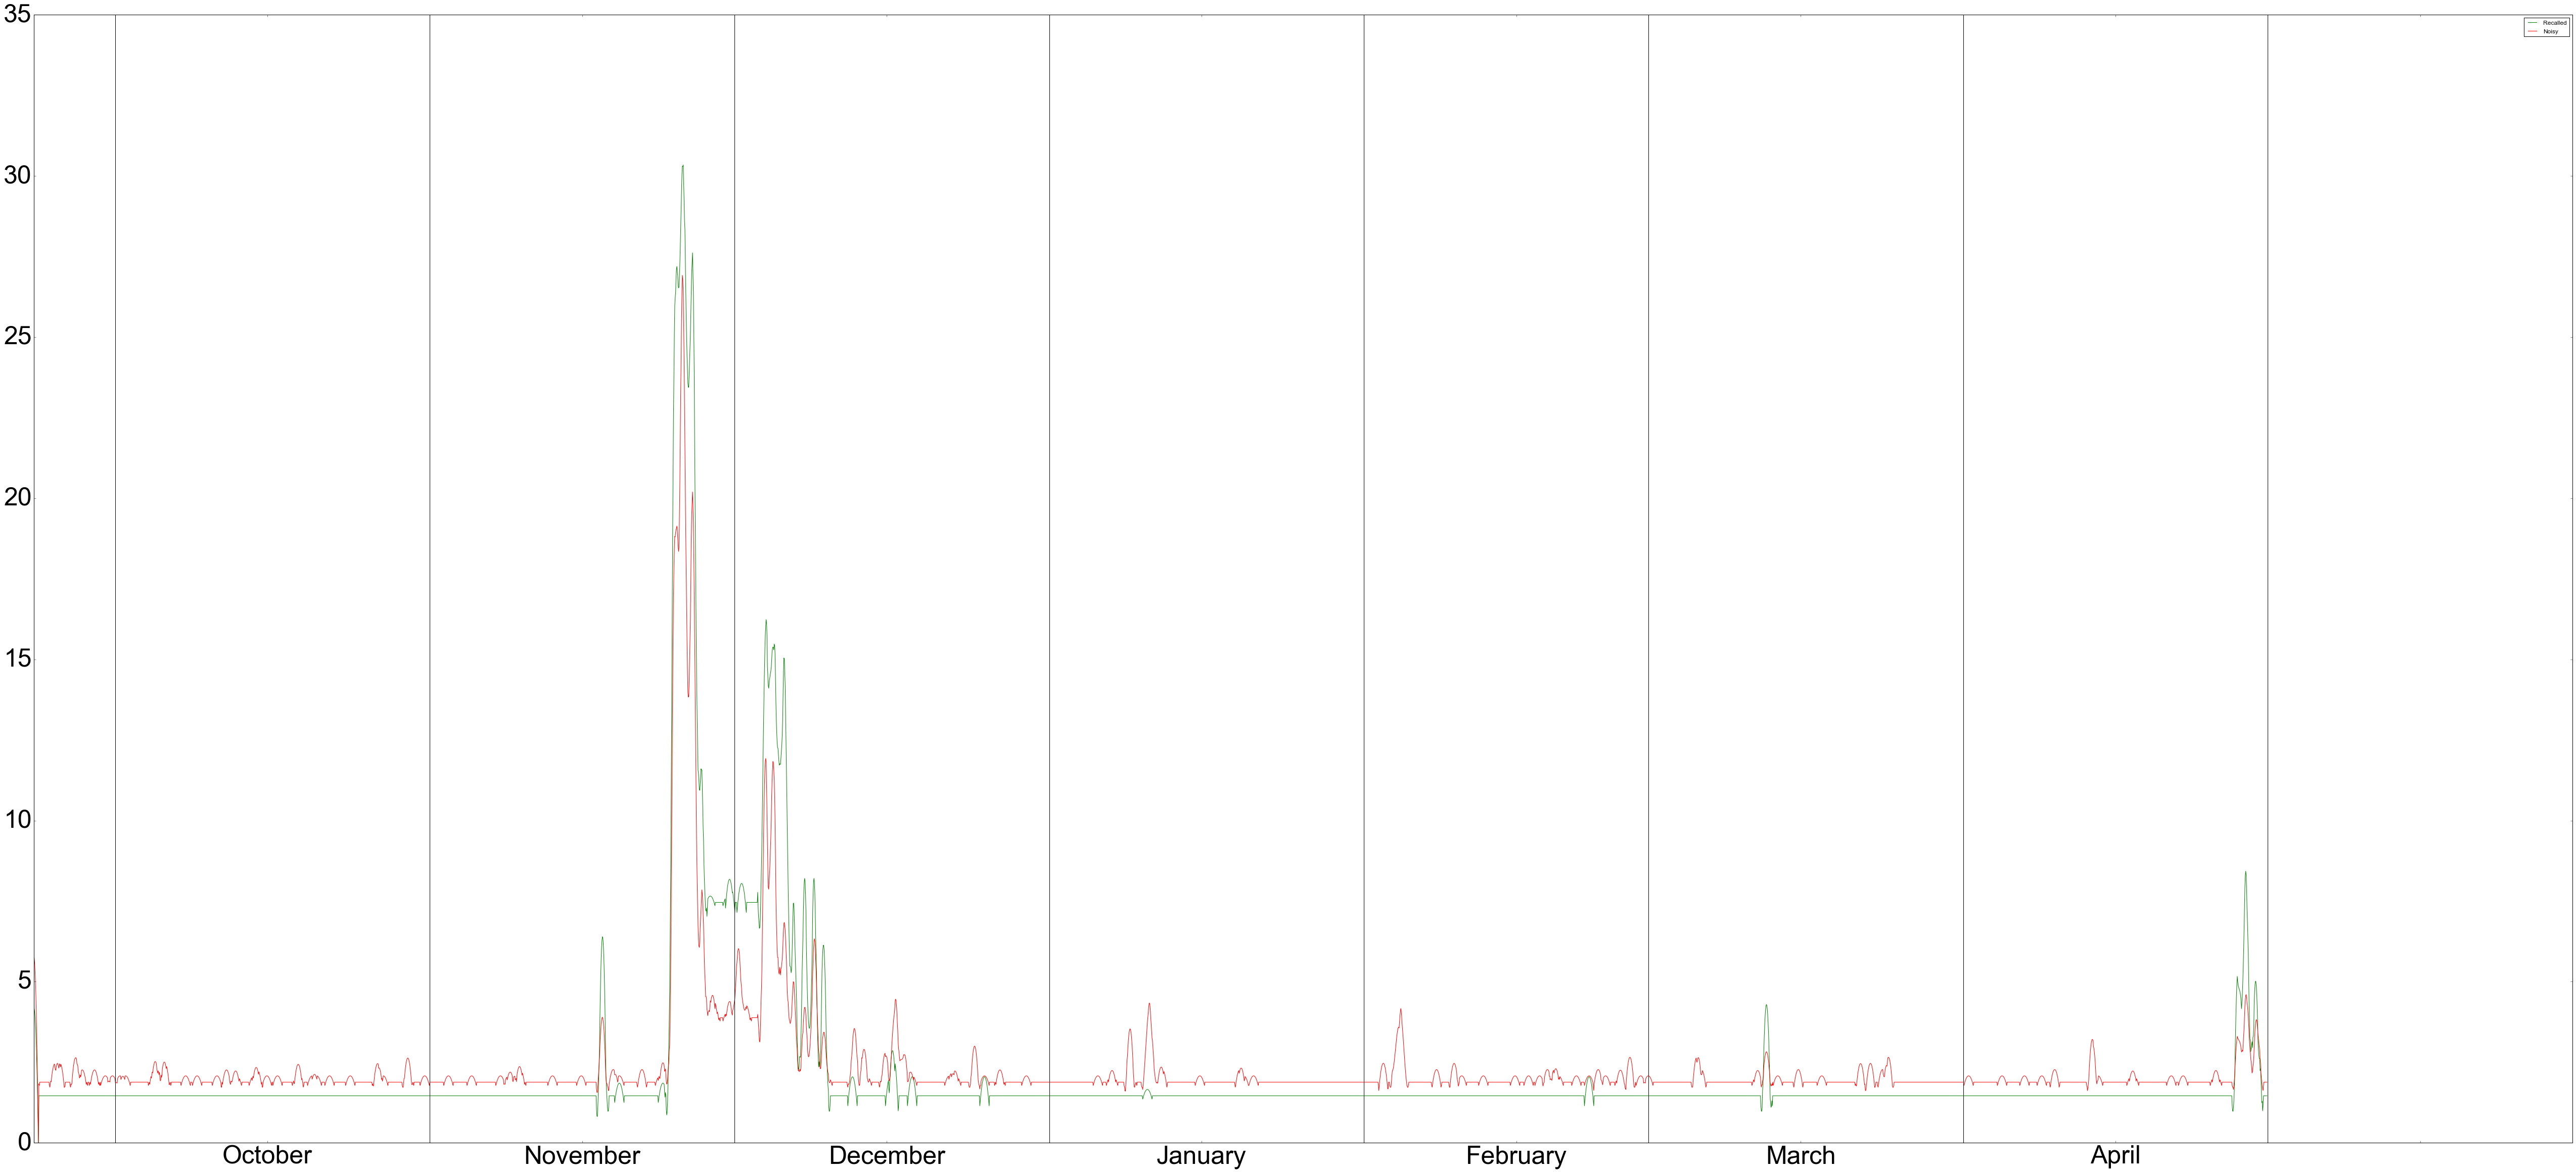

In [67]:
pl.plot(filtered_recalled - min(filtered_recalled), 'g', label="Recalled")
pl.plot(filtered_degraded - min(filtered_degraded), 'r', label="Noisy")
# pl.plot(filtered - min(filtered), 'b', label="Original")
pl.legend()
for xc in x_month:
    pl.axvline(x=xc, linewidth=1, color = 'black')
#pl.axvline(x = x_month[3] + 6*24, linewidth=5, color = 'b') #Charlie Hebdo
#pl.axvline(x = x_month[3] + 24*24, linewidth=5, color = 'g') #Miss Universe
#pl.axvline(x = x_month[3] + 9*24, linewidth=5, color = 'm') #Golden Globe
pl.xticks([i + 15*24 for i in x_month], [month for month in months])
pl.show()